In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing of Necessary Libraries

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [3]:
# Load mean and std values from the JSON file
with open('/content/drive/MyDrive/ML Project/mean_std.json', 'r') as f:
    mean_std = json.load(f)
mean = np.array(mean_std['mean'])
std = np.array(mean_std['std'])

# Initialization of Inception v3 Model

In [4]:
# Define the InceptionV3 model with pretrained weights
def get_inceptionv3_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False

  # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Dropout layer with 50% dropout rate
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [5]:
# Define a transform that includes normalization with the previously computed mean and std
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True
)
train_datagen.mean = mean
train_datagen.std = std

val_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
val_datagen.mean = mean
val_datagen.std = std


In [6]:
# Training and Evaluation Functions
def train_model(model, train_generator, val_generator, num_epochs=20, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5, verbose=1)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    return model, history

def evaluate_model(model, generator):
    results = model.evaluate(generator)
    return results


# Training of Inception v3 Model

In [7]:
# Base directory containing the k-fold datasets
base_dir = '/content/drive/MyDrive/ML Project/dataset_kfold'

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')

    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),  # Image size specified here
        batch_size=16,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(299, 299),  # Image size specified here
        batch_size=16,
        class_mode='categorical'
    )

    # Get the model and compile it
    num_classes = len(train_generator.class_indices)
    model = get_inceptionv3_model(num_classes)
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(
        model, train_generator, val_generator, num_epochs=20, patience=3)

    # Save the model for this fold
    model_path = f'/content/drive/MyDrive/ML Project/inceptionv3_fold_{fold}.h5'
    model.save(model_path)
    print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')
    print(f'Training and evaluation for fold {fold} completed.\n')


Starting training for fold 0...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
24/24 [==============================] - 151s 6s/step - loss: 1.5856 - accuracy: 0.4740 - val_loss: 0.8918 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 5s 220ms/step - loss: 0.7684 - accuracy: 0.7214 - val_loss: 0.7976 - val_accuracy: 0.7604 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 5s 209ms/step - loss: 0.6300 - accuracy: 0.7839 - val_loss: 0.7170 - val_accuracy: 0.8021 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 6s 255ms/step - loss: 0.4324 - accuracy: 0.8359 - val_loss: 0.6464 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - 5s 208ms/step - loss: 0.3255 - accuracy: 0.8750 - val_loss: 0.5793 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 6/20
24/24 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 0 saved at /content/drive/MyDrive/ML Project/inceptionv3_fold_0.h5
Evaluating model for fold 0...
6/6 [==============================] - 1s 177ms/step - loss: 0.3505 - accuracy: 0.8750
Val loss: 0.3505, Val accuracy: 87.5000
Training and evaluation for fold 0 completed.

Starting training for fold 1...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
24/24 [==============================] - 112s 4s/step - loss: 1.3498 - accuracy: 0.5365 - val_loss: 1.0278 - val_accuracy: 0.5521 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 6s 263ms/step - loss: 0.7380 - accuracy: 0.7370 - val_loss: 0.8825 - val_accuracy: 0.7604 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 5s 205ms/step - loss: 0.4990 - accuracy: 0.8333 - val_loss: 0.7963 - val_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 6s 254ms/step - loss: 0.3431 - accuracy: 0.8724 - val_loss: 0.7095 - val

# Classification Report and Confusion Matrix

Loading model for fold 0...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 169ms/step
Fold 0 - ROC-AUC for class glioma: 0.9856
Fold 0 - ROC-AUC for class meningioma: 0.9580
Fold 0 - ROC-AUC for class notumor: 0.9976
Fold 0 - ROC-AUC for class pituitary: 0.9659


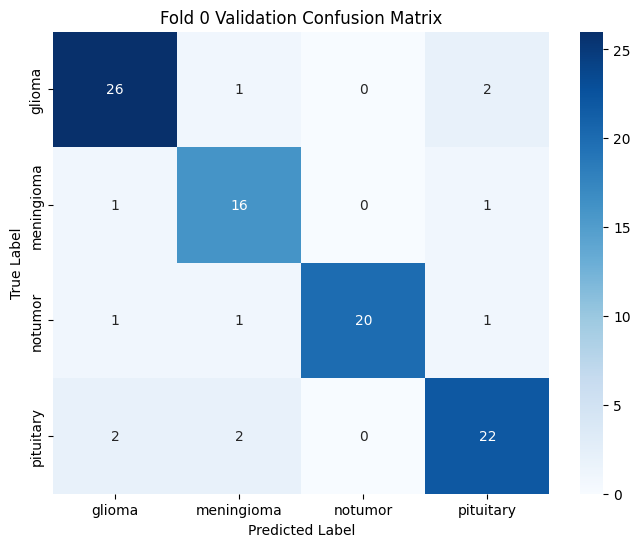

Classification Report for Fold 0:
              precision    recall  f1-score   support

      glioma       0.87      0.90      0.88        29
  meningioma       0.80      0.89      0.84        18
     notumor       1.00      0.87      0.93        23
   pituitary       0.85      0.85      0.85        26

    accuracy                           0.88        96
   macro avg       0.88      0.88      0.87        96
weighted avg       0.88      0.88      0.88        96

Class-wise TP, TN, FP, FN for Fold 0:
Class: glioma, TP: 26, TN: 63, FP: 4, FN: 3
Class: meningioma, TP: 16, TN: 74, FP: 4, FN: 2
Class: notumor, TP: 20, TN: 73, FP: 0, FN: 3
Class: pituitary, TP: 22, TN: 66, FP: 4, FN: 4
Loading model for fold 1...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 153ms/step
Fold 1 - ROC-AUC for class glioma: 0.9808
Fold 1 - ROC-AUC for class meningioma: 0.9132
Fold 1 - ROC-AUC for class notumor: 0.9802
Fold 1 - ROC-AUC for class pituitary: 0.9544


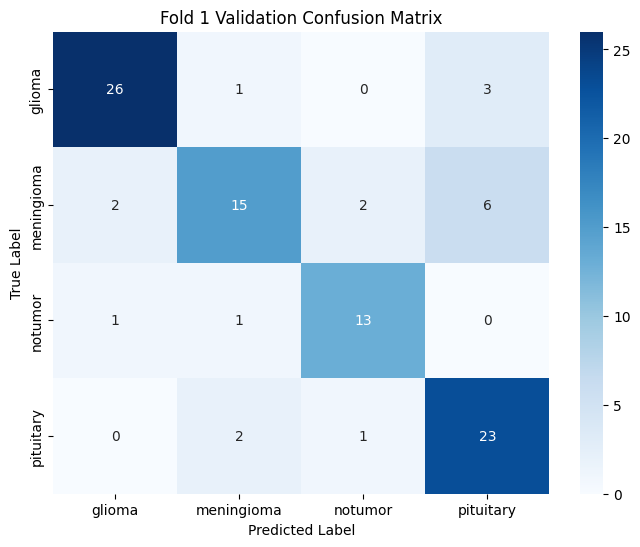

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.90      0.87      0.88        30
  meningioma       0.79      0.60      0.68        25
     notumor       0.81      0.87      0.84        15
   pituitary       0.72      0.88      0.79        26

    accuracy                           0.80        96
   macro avg       0.80      0.80      0.80        96
weighted avg       0.81      0.80      0.80        96

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 26, TN: 63, FP: 3, FN: 4
Class: meningioma, TP: 15, TN: 67, FP: 4, FN: 10
Class: notumor, TP: 13, TN: 78, FP: 3, FN: 2
Class: pituitary, TP: 23, TN: 61, FP: 9, FN: 3
Loading model for fold 2...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 157ms/step
Fold 2 - ROC-AUC for class glioma: 0.9672
Fold 2 - ROC-AUC for class meningioma: 0.8533
Fold 2 - ROC-AUC for class notumor: 0.9652
Fold 2 - ROC-AUC for class pituitary: 0.9693


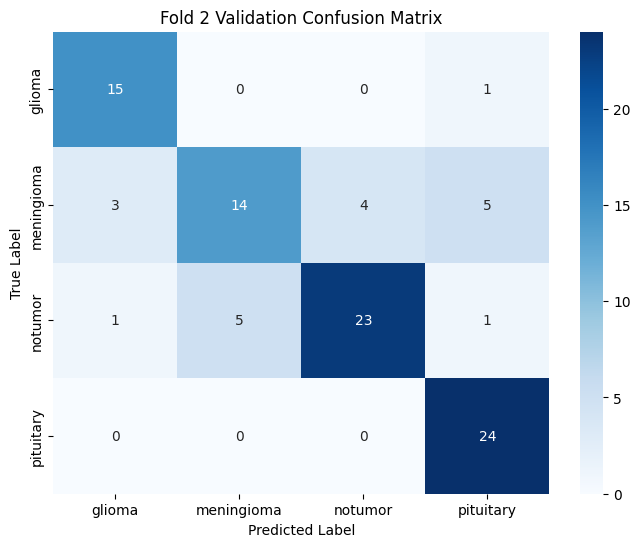

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.79      0.94      0.86        16
  meningioma       0.74      0.54      0.62        26
     notumor       0.85      0.77      0.81        30
   pituitary       0.77      1.00      0.87        24

    accuracy                           0.79        96
   macro avg       0.79      0.81      0.79        96
weighted avg       0.79      0.79      0.78        96

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 15, TN: 76, FP: 4, FN: 1
Class: meningioma, TP: 14, TN: 65, FP: 5, FN: 12
Class: notumor, TP: 23, TN: 62, FP: 4, FN: 7
Class: pituitary, TP: 24, TN: 65, FP: 7, FN: 0
Loading model for fold 3...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 161ms/step
Fold 3 - ROC-AUC for class glioma: 0.9696
Fold 3 - ROC-AUC for class meningioma: 0.9002
Fold 3 - ROC-AUC for class notumor: 0.9914
Fold 3 - ROC-AUC for class pituitary: 0.9839


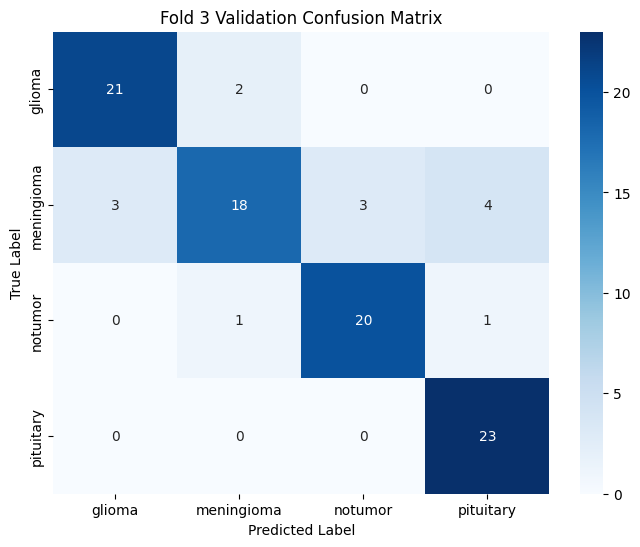

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.88      0.91      0.89        23
  meningioma       0.86      0.64      0.73        28
     notumor       0.87      0.91      0.89        22
   pituitary       0.82      1.00      0.90        23

    accuracy                           0.85        96
   macro avg       0.86      0.87      0.85        96
weighted avg       0.86      0.85      0.85        96

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 21, TN: 70, FP: 3, FN: 2
Class: meningioma, TP: 18, TN: 65, FP: 3, FN: 10
Class: notumor, TP: 20, TN: 71, FP: 3, FN: 2
Class: pituitary, TP: 23, TN: 68, FP: 5, FN: 0
Loading model for fold 4...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 3s 160ms/step
Fold 4 - ROC-AUC for class glioma: 0.9951
Fold 4 - ROC-AUC for class meningioma: 0.8803
Fold 4 - ROC-AUC for class notumor: 0.9773
Fold 4 - ROC-AUC for class pituitary: 0.9905


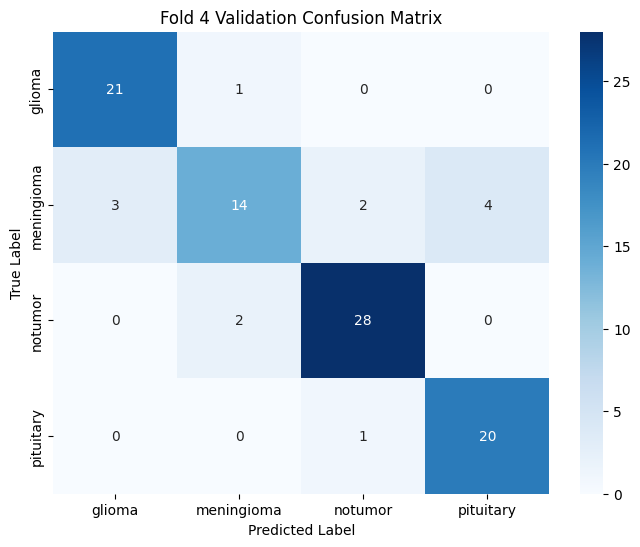

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.88      0.95      0.91        22
  meningioma       0.82      0.61      0.70        23
     notumor       0.90      0.93      0.92        30
   pituitary       0.83      0.95      0.89        21

    accuracy                           0.86        96
   macro avg       0.86      0.86      0.85        96
weighted avg       0.86      0.86      0.86        96

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 21, TN: 71, FP: 3, FN: 1
Class: meningioma, TP: 14, TN: 70, FP: 3, FN: 9
Class: notumor, TP: 28, TN: 63, FP: 3, FN: 2
Class: pituitary, TP: 20, TN: 71, FP: 4, FN: 1


In [10]:
# Confusion Matrix, AUC-ROC, and Classification Report for each fold
for fold in range(5):
    print(f'Loading model for fold {fold}...')
    model_path = f'/content/drive/MyDrive/ML Project/inceptionv3_fold_{fold}.h5'
    model = tf.keras.models.load_model(model_path)

    # Load the validation dataset for the current fold
    val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(299, 299),  # Image size specified here
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Make predictions on the validation data
    val_predictions = model.predict(val_generator)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = val_generator.classes

    # Compute the confusion matrix for this fold
    val_conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

    # Compute the AUC-ROC for each class
    val_true_classes_one_hot = tf.keras.utils.to_categorical(val_true_classes, num_classes)
    auc_roc_scores = {}
    for i, class_name in enumerate(val_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(val_true_classes_one_hot[:, i], val_predictions[:, i])
        roc_auc = auc(fpr, tpr)
        auc_roc_scores[class_name] = roc_auc
        print(f'Fold {fold} - ROC-AUC for class {class_name}: {roc_auc:.4f}')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold}:')
    print(classification_report(val_true_classes, val_predictions_classes, target_names=list(val_generator.class_indices.keys())))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = val_conf_matrix[i, i]
        fp = np.sum(val_conf_matrix[:, i]) - tp
        fn = np.sum(val_conf_matrix[i, :]) - tp
        tn = np.sum(val_conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")


# Visualizes the train vs. validation metrics

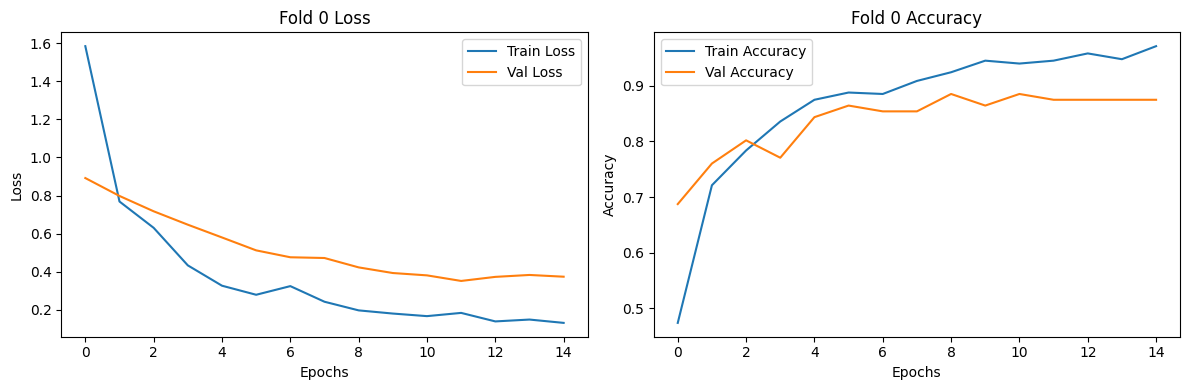

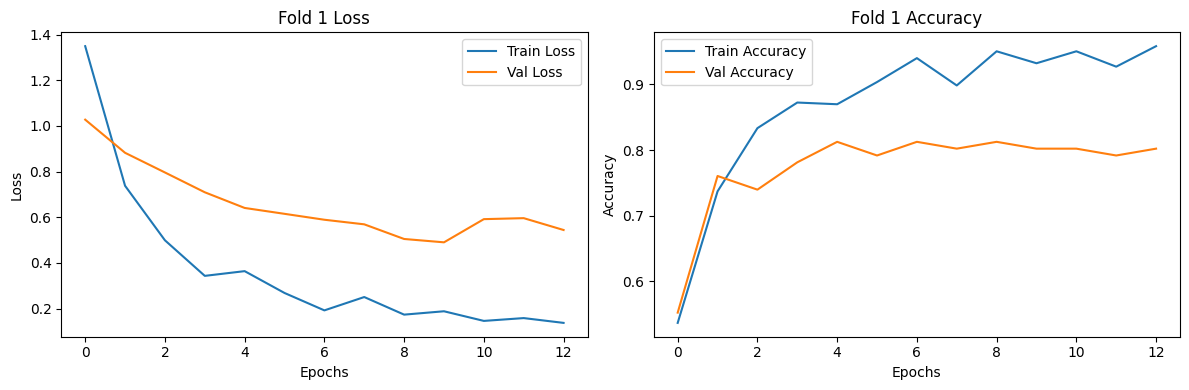

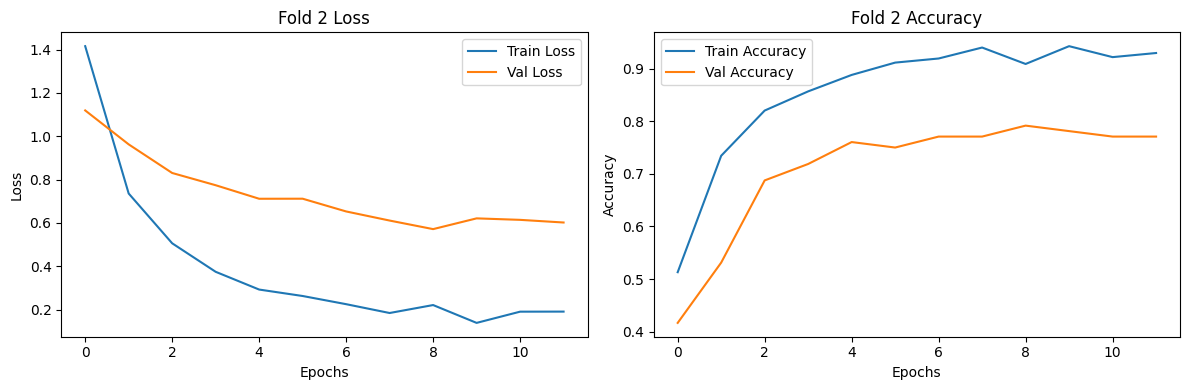

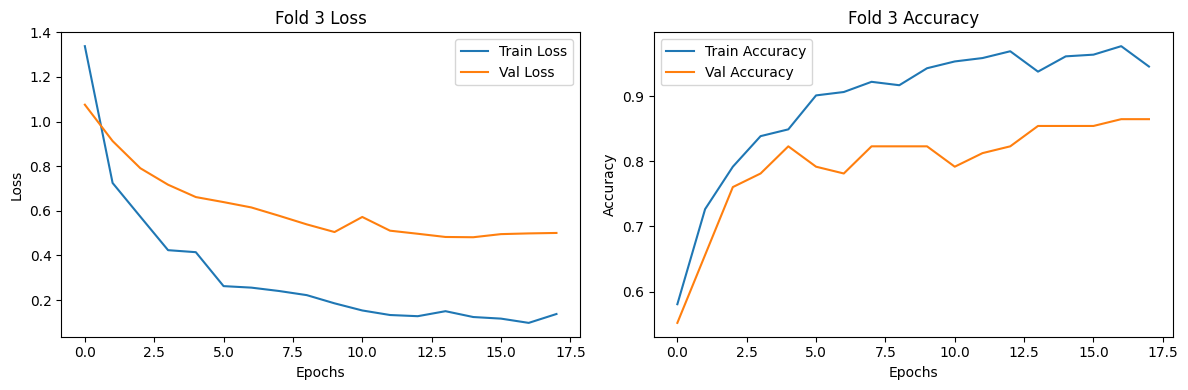

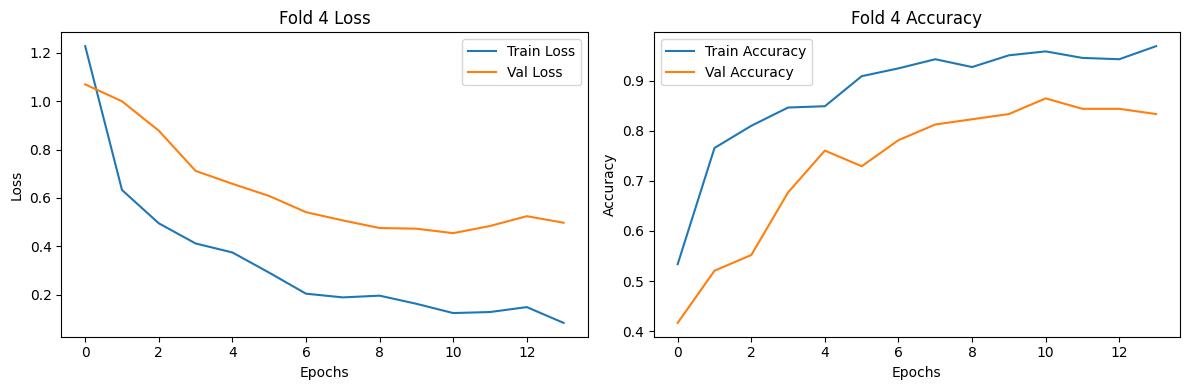

Accuracies for each fold:
Fold 0: 87.50%
Fold 1: 80.21%
Fold 2: 79.17%
Fold 3: 85.42%
Fold 4: 86.46%


In [11]:
# Plotting Results and Printing Fold Accuracies
def plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies):
    for fold in range(5):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[fold], label='Train Loss')
        plt.plot(all_val_losses[fold], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(all_train_accuracies[fold], label='Train Accuracy')
        plt.plot(all_val_accuracies[fold], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")


# Using trained model to predict and display predicted image

In [14]:
# Define the function to predict a random image
def predict_random_image(base_dir, model_path, target_size=(299, 299)):
    # Load the model
    model = load_model(model_path)

    # Get a list of all class directories
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Choose a random class directory
    random_class = random.choice(class_dirs)
    random_class_dir = os.path.join(base_dir, random_class)

    # Get a list of all images in the chosen class directory
    image_files = [f for f in os.listdir(random_class_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    # Choose a random image file
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(random_class_dir, random_image_file)

    # Load and preprocess the image
    img = load_img(random_image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array -= mean
    img_array /= std

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the class labels
    class_labels = {v: k for k, v in val_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    # Display the image with predicted and true labels
    plt.imshow(img)
    plt.title(f"True: {random_class}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Base directory containing the dataset
base_dir = '/content/drive/MyDrive/ML Project/dataset_kfold/fold_0/val'

# Path to the saved model from fold 0
model_path = '/content/drive/MyDrive/ML Project/inceptionv3_fold_0.h5'


1/1 [==============================] - 2s 2s/step


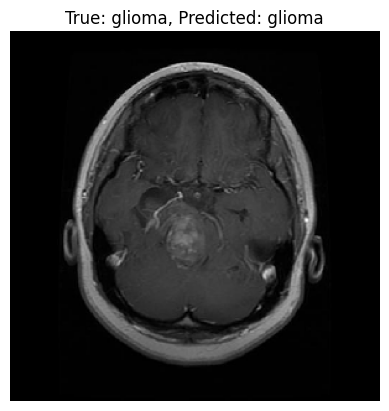

In [16]:
# Predict and display a random image
predict_random_image(base_dir, model_path, target_size=(299, 299))